# Delay-dependent post-decision bias

In [1]:
import sys
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm, wilcoxon, pearsonr, spearmanr
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from statsmodels.stats.weightstats import DescrStatsW

sys.path.append('..')
from src import utils
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/processed/behavior")
utils.download_dataset("data/outputs/fmri")
utils.download_dataset("data/outputs/ddm")

behavior = pd.read_csv("../data/processed/behavior/behavior.csv")
behavior = behavior[(~np.isnan(behavior['choice'])) & (~np.isnan(behavior['error']))]

with open('../data/outputs/ddm/demo_post_decision_bias.pickle', 'rb') as f:
    dcb_demo = pickle.load(f)

with open('../data/outputs/ddm/results_decision_consistent_bias.pickle', 'rb') as f:
    dcb_ddm = pickle.load(f)

with open('../data/outputs/fmri/results_decision_consistent_bias.pickle', 'rb') as f:
    dcb_bold = pickle.load(f)

downloading data/processed/behavior...
data/processed/behavior already exists. Skipping download...
downloading data/outputs/fmri...
data/outputs/fmri already exists. Skipping download...
downloading data/outputs/ddm...
data/outputs/ddm already exists. Skipping download...


---
## Schematic

In [3]:
d_bpre  = dcb_demo['bpre'][:,:,1]  - dcb_demo['bpre'][:,:,0]
d_bpost = dcb_demo['bpost'][:,:,1] - dcb_demo['bpost'][:,:,0]

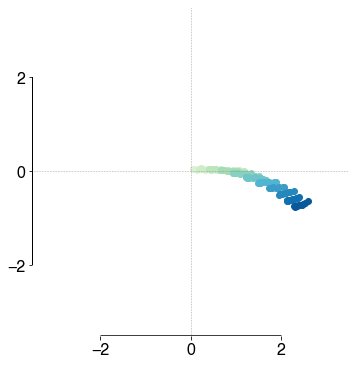

In [4]:
lim = 3.5
plt.figure()
ax = plt.gca()
utils.set_size([4,4])

plt.axvline(x=0, linestyle='dotted', color='gray', linewidth=0.6)
plt.axhline(y=0, linestyle='dotted', color='gray', linewidth=0.6)

plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

for i_w, w_K in enumerate(dcb_demo['w_K']):
    plt.scatter(d_bpre[i_w], d_bpost[i_w], color=utils.BLUES.colors[1+i_w])
utils.draw_publish_axis(ax, xrange=(-2,2), yrange=(-2,2), xticks=[-2,0,2], yticks=[-2,0,2])
plt.savefig(f'{utils.DIR_FIGURE}/fig6b_left.pdf',bbox_inches='tight')
plt.show()

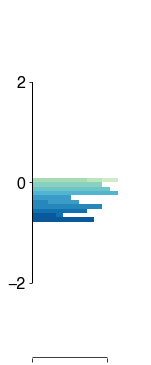

In [5]:
lim = 3.5
plt.figure()
ax = plt.gca()
utils.set_size([1.8,4])

for i_w, w_K in enumerate(dcb_demo['w_K']):    
    plt.hist(d_bpost[i_w], color=utils.BLUES.colors[1+i_w], 
             range=[-lim,lim], bins=80, density=True, orientation='horizontal')    

plt.xlim([0,15])
plt.ylim([-lim,lim])
ax.set_xticks([0,10])
ax.set_xticklabels([])

utils.draw_publish_axis(ax, xrange=(0,10), yrange=(-2,2), xticks=None, yticks=[-2,0,2])
plt.savefig(f'{utils.DIR_FIGURE}/fig6b_right.pdf',bbox_inches='tight')
plt.show()

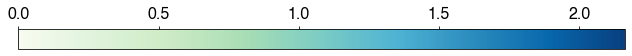

In [6]:
fig, ax = plt.subplots(figsize=(9,1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.GnBu
_nm  = mpl.colors.Normalize(vmin=0, vmax=dcb_demo['w_K'][-1])

fig.colorbar(mpl.cm.ScalarMappable(norm=_nm, cmap=cmap), cax=ax, orientation='horizontal')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_ticks([0,0.5,1,1.5,2])
plt.tight_layout()
plt.savefig(f'{utils.DIR_FIGURE}/fig6b_upper.pdf',bbox_inches='tight')
plt.show()

---
## Behavior

In [7]:
esti   = behavior.esti.to_numpy()
error  = behavior.error.to_numpy()
evi    = -behavior.ref.to_numpy()
ref    = behavior.ref.to_numpy()
dm     = 2.-behavior.choice.to_numpy()
timing = behavior.Timing.to_numpy()
subid  = behavior.ID.to_numpy()
subids = np.unique(subid)
n_sam  = 100000

def nll_EL(par, evi, dm, tim):
    m, s1, s2_add, lam = par
    s2        = np.sqrt(s1**2 + s2_add**2)
    probE     = utils.psi(evi[tim==1], m, s1, lam)
    probL     = utils.psi(evi[tim==2], m, s2, lam)
    sumE_ll   = np.sum(np.log(probE[dm[tim==1]==1])) + np.sum(np.log(1.-probE[dm[tim==1]==0]))
    sumL_ll   = np.sum(np.log(probL[dm[tim==2]==1])) + np.sum(np.log(1.-probL[dm[tim==2]==0]))
    return -sumE_ll - sumL_ll

In [8]:
res_mat = np.zeros([len(subids),4]) * np.nan
for i_id, v_id in enumerate(subids):
    _timing = timing[subid==v_id]
    _evi    = evi[subid==v_id]
    _dm     = dm[subid==v_id]

    res = minimize(nll_EL, [0,5.,5.,0], args = (_evi, _dm, _timing), 
                   bounds = [[-30., 30.], [utils.EPS, 30.], [utils.EPS, 10.], [utils.EPS, 0.5]])
    res_mat[i_id, :] = res['x']    

In [9]:
np.random.seed(2023)
cmd_indv = np.zeros((len(subids),2,2)) # EL / CWCCW
cmd_pred = np.zeros((len(subids),2,2)) # EL / CWCCW

for i_id, v_id in enumerate(subids):
    err_e = error[(subid==v_id)&(np.abs(evi)<5)&(timing==1)]
    err_l = error[(subid==v_id)&(np.abs(evi)<5)&(timing==2)]
    dm_e  = dm[(subid==v_id)&(np.abs(evi)<5)&(timing==1)]
    dm_l  = dm[(subid==v_id)&(np.abs(evi)<5)&(timing==2)]

    cmd_indv[i_id,0,0] = err_e[dm_e==0].mean()
    cmd_indv[i_id,0,1] = err_e[dm_e==1].mean()
    cmd_indv[i_id,1,0] = err_l[dm_l==0].mean()
    cmd_indv[i_id,1,1] = err_l[dm_l==1].mean()
    
    idx = (subid==v_id) & (timing==1)
    lin = LinearRegression().fit(ref[idx].reshape((-1,1)), error[idx])
    b_e = lin.coef_[0]
    idx = (subid==v_id) & (timing==2)
    lin = LinearRegression().fit(ref[idx].reshape((-1,1)), error[idx])
    b_l = lin.coef_[0]
    
    _s1  = res_mat[i_id,1]
    _s2  = np.sqrt(_s1**2 + res_mat[i_id,2]**2)
    r   = np.random.choice([-4,0,4],size=n_sam)
    x_e = norm.rvs(loc=res_mat[i_id,0], scale=_s1, size=n_sam); d_e = (x_e>r)*1
    x_l = norm.rvs(loc=res_mat[i_id,0], scale=_s2, size=n_sam); d_l = (x_l>r)*1
    
    # attraction correction
    x_e = (1.-b_e)*x_e + b_e*r
    x_l = (1.-b_l)*x_l + b_l*r
    
    # With lapses
    lam_e = np.random.choice([0,1], len(d_e), p=[1.-res_mat[i_id,3]*2, res_mat[i_id,3]*2], replace=True)
    lam_l = np.random.choice([0,1], len(d_l), p=[1.-res_mat[i_id,3]*2, res_mat[i_id,3]*2], replace=True)
    d_e[lam_e==1] = np.random.choice([0,1], sum(lam_e), p=[0.5,0.5], replace=True)
    d_l[lam_l==1] = np.random.choice([0,1], sum(lam_l), p=[0.5,0.5], replace=True)
    
    cmd_pred[i_id,0,0] = x_e[d_e==0].mean()
    cmd_pred[i_id,0,1] = x_e[d_e==1].mean()
    cmd_pred[i_id,1,0] = x_l[d_l==0].mean()
    cmd_pred[i_id,1,1] = x_l[d_l==1].mean()

In [10]:
# [n_subj, early/late]
bpre    = (cmd_pred[:,:,1] - cmd_pred[:,:,0])/2.
bpost   = (cmd_indv[:,:,1] - cmd_indv[:,:,0])/2. - bpre
d_bpre  = bpre[:,1]  - bpre[:,0]
d_bpost = bpost[:,1] - bpost[:,0]

In [11]:
X = np.array([d_bpre]).T
y = np.array([d_bpost]).T
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

spear = spearmanr(d_bpre,d_bpost)
pears = pearsonr(d_bpre,d_bpost)
pears_CI = utils.pearson_CI(d_bpre,d_bpost)
print('Relation between d_bpre and d_bpost')
print('\nLinear regression')
print(f'Coefficient: {est2.params[-1]}')
print(f'p-value: {est2.pvalues[-1]}')
print('\nCorrelation coefficient')
print('Pearson r=', pears[0], 'p=', pears[1])
print('Pearson CI=', pears_CI)
print('Spearman rho=', spear.correlation, 'p=', spear.pvalue)
print(spearmanr(d_bpre,d_bpost))

Relation between d_bpre and d_bpost

Linear regression
Coefficient: -0.8746647323244201
p-value: 5.065668655876804e-05

Correlation coefficient
Pearson r= -0.540580007594685 p= 5.065668655876814e-05
Pearson CI= (-0.7118206360730923, -0.3086789704474051)
Spearman rho= -0.6216086434573829 p= 1.451978660176381e-06
SpearmanrResult(correlation=-0.6216086434573829, pvalue=1.451978660176381e-06)


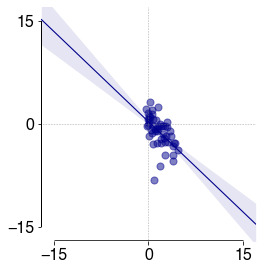

In [12]:
lim = 17
plt.figure()
ax = plt.gca()
utils.set_size([3,3])

plt.axvline(x=0, linestyle='dotted', color='gray', linewidth=0.6)
plt.axhline(y=0, linestyle='dotted', color='gray', linewidth=0.6)
plt.scatter(d_bpre, d_bpost, color='darkblue', alpha=0.5, s=50)

x_line  = np.linspace(-lim,lim,100)
x_mean  = np.mean(d_bpre)
se_line = est2.scale * (1/50 + (x_line-x_mean)**2/np.sum((d_bpre-x_mean)**2))
se_line = se_line**0.5
y_line = est2.params[0] + x_line * est2.params[1]
plt.plot(x_line, y_line, color='darkblue', linewidth=1.1)
plt.fill_between(x_line, y_line-se_line, y_line+se_line, color='darkblue', alpha=0.1, linewidth=0, zorder=-3)

plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

utils.draw_publish_axis(ax, xrange=(-15,15), yrange=(-15,15), xticks=[-15,0,15], yticks=[-15,0,15])
plt.savefig(f'{utils.DIR_FIGURE}/fig6c_left.pdf',bbox_inches='tight')
plt.show()

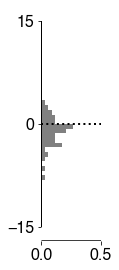

In [13]:
lim = 17
plt.figure()
ax = plt.gca()
utils.set_size([1.5,3])

plt.axhline(y=0, linestyle='dotted', color='k', linewidth=2)
plt.hist(d_bpost, bins=50, range=[-lim,lim], color='gray', 
         orientation='horizontal', density=True)

plt.xlim([0,0.5])
plt.ylim([-lim,lim])

utils.draw_publish_axis(ax, xrange=(0,0.5), yrange=(-15,15), xticks=None, yticks=[-15,0,15])
plt.savefig(f'{utils.DIR_FIGURE}/fig6c_right.pdf',bbox_inches='tight')
plt.show()

In [14]:
ttest  = DescrStatsW(d_bpost)
wilcox = wilcoxon(d_bpost)
print("d_bpost vs. 0")
print('\nOne-sample t-test (two-sided)')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nOne-sample t-test (one-sided)')
if ttest.ttest_mean()[0] < 0:
    p_val = ttest.ttest_mean()[1]/2
else:
    p_val = (1.-ttest.ttest_mean()[1])/2
print('t(49)=',  ttest.ttest_mean()[0], 'p=', p_val)
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

d_bpost vs. 0

One-sample t-test (two-sided)
t(49)= -3.6115536771478243 p= 0.0007151186719621784
95% CI= (-1.788332833605331, -0.5096610828126348)

One-sample t-test (one-sided)
t(49)= -3.6115536771478243 p= 0.0003575593359810892

Wilcoxon signed-rank test (without continuity correction)
V= 303.0 p= 0.0012421446192700297


---
## BOLD responses

In [15]:
d_bpre  = dcb_bold['bpre'][:,1]  - dcb_bold['bpre'][:,0]
d_bpost = dcb_bold['bpost'][:,1] - dcb_bold['bpost'][:,0]

In [16]:
X = np.array([d_bpre]).T
y = np.array([d_bpost]).T
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

spear = spearmanr(d_bpre,d_bpost)
pears = pearsonr(d_bpre,d_bpost)
pears_CI = utils.pearson_CI(d_bpre,d_bpost)
print('Relation between d_bpre and d_bpost')
print('\nLinear regression')
print(f'Coefficient: {est2.params[-1]}')
print(f'p-value: {est2.pvalues[-1]}')
print('\nCorrelation coefficient')
print('Pearson r=', pears[0], 'p=', pears[1])
print('Pearson CI=', pears_CI)
print('Spearman rho=', spear.correlation, 'p=', spear.pvalue)
print(spearmanr(d_bpre,d_bpost))

Relation between d_bpre and d_bpost

Linear regression
Coefficient: -0.3613371314512601
p-value: 0.008727901967488409

Correlation coefficient
Pearson r= -0.36711841861353706 p= 0.008727901967488384
Pearson CI= (-0.585623298469931, -0.09887432905219641)
Spearman rho= -0.2971908763505402 p= 0.036089489054343275
SpearmanrResult(correlation=-0.2971908763505402, pvalue=0.036089489054343275)


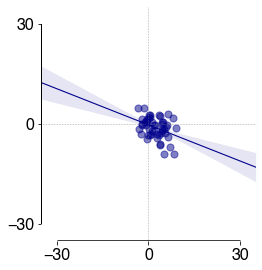

In [17]:
lim = 35
plt.figure()
ax = plt.gca()
utils.set_size([3,3])

plt.axvline(x=0, linestyle='dotted', color='gray', linewidth=0.6)
plt.axhline(y=0, linestyle='dotted', color='gray', linewidth=0.6)
plt.scatter(d_bpre, d_bpost, color='darkblue', alpha=0.5, s=50)

x_line  = np.linspace(-lim,lim,100)
x_mean  = np.mean(d_bpre)
se_line = est2.scale * (1/50 + (x_line-x_mean)**2/np.sum((d_bpre-x_mean)**2))
se_line = se_line**0.5
y_line = est2.params[0] + x_line * est2.params[1]
plt.plot(x_line, y_line, color='darkblue', linewidth=1.1)
plt.fill_between(x_line, y_line-se_line, y_line+se_line, color='darkblue', alpha=0.1, linewidth=0, zorder=-3)

plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

utils.draw_publish_axis(ax, xrange=(-30,30), yrange=(-30,30), xticks=[-30,0,30], yticks=[-30,0,30])
plt.savefig(f'{utils.DIR_FIGURE}/fig6d_left.pdf',bbox_inches='tight')
plt.show()

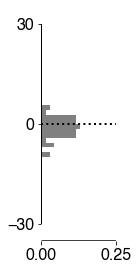

In [18]:
plt.figure()
ax = plt.gca()
utils.set_size([1.5,3])

plt.axhline(y=0, linestyle='dotted', color='k', linewidth=2)
plt.hist(d_bpost, bins=50, range=[-lim,lim], color='gray', 
         orientation='horizontal', density=True)

plt.xlim([0,0.25])
plt.ylim([-lim,lim])

utils.draw_publish_axis(ax, xrange=(0,0.25), yrange=(-30,30), xticks=None, yticks=[-30,0,30])
plt.savefig(f'{utils.DIR_FIGURE}/fig6d_right.pdf',bbox_inches='tight')
plt.show()

In [19]:
ttest  = DescrStatsW(d_bpost)
wilcox = wilcoxon(d_bpost)
print("d_bpost vs. 0")
print('\nOne-sample t-test (two-sided)')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nOne-sample t-test (one-sided)')
if ttest.ttest_mean()[0] < 0:
    p_val = ttest.ttest_mean()[1]/2
else:
    p_val = (1.-ttest.ttest_mean()[1])/2
print('t(49)=',  ttest.ttest_mean()[0], 'p=', p_val)
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

d_bpost vs. 0

One-sample t-test (two-sided)
t(49)= -2.485310571214301 p= 0.01640537855754956
95% CI= (-2.001774160591225, -0.2118662732494947)

One-sample t-test (one-sided)
t(49)= -2.485310571214301 p= 0.00820268927877478

Wilcoxon signed-rank test (without continuity correction)
V= 416.0 p= 0.0325004148959391


---
## DDM: full model

In [20]:
d_bpre  = dcb_ddm['bpre'][0,:,1]  - dcb_ddm['bpre'][0,:,0]
d_bpost = dcb_ddm['bpost'][0,:,1] - dcb_ddm['bpost'][0,:,0]

In [21]:
X = np.array([d_bpre]).T
y = np.array([d_bpost]).T
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

spear = spearmanr(d_bpre,d_bpost)
pears = pearsonr(d_bpre,d_bpost)
pears_CI = utils.pearson_CI(d_bpre,d_bpost)
print('Relation between d_bpre and d_bpost')
print('\nLinear regression')
print(f'Coefficient: {est2.params[-1]}')
print(f'p-value: {est2.pvalues[-1]}')
print('\nCorrelation coefficient')
print('Pearson r=', pears[0], 'p=', pears[1])
print('Pearson CI=', pears_CI)
print('Spearman rho=', spear.correlation, 'p=', spear.pvalue)
print(spearmanr(d_bpre,d_bpost))

Relation between d_bpre and d_bpost

Linear regression
Coefficient: -0.23835631085232653
p-value: 1.014704463331758e-09

Correlation coefficient
Pearson r= -0.7373610826662844 p= 1.01470446333175e-09
Pearson CI= (-0.8427420783479748, -0.5775516720729639)
Spearman rho= -0.7551020408163265 p= 2.3638824773100394e-10
SpearmanrResult(correlation=-0.7551020408163265, pvalue=2.3638824773100394e-10)


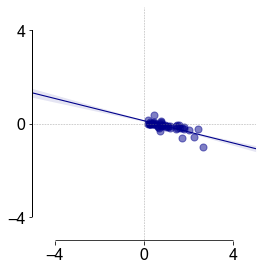

In [22]:
lim = 5
plt.figure()
ax = plt.gca()
utils.set_size([3,3])

plt.axvline(x=0, linestyle='dotted', color='gray', linewidth=0.6)
plt.axhline(y=0, linestyle='dotted', color='gray', linewidth=0.6)
plt.scatter(d_bpre, d_bpost, color='darkblue', alpha=0.5, s=50)

x_line  = np.linspace(-lim,lim,100)
x_mean  = np.mean(d_bpre)
se_line = est2.scale * (1/50 + (x_line-x_mean)**2/np.sum((d_bpre-x_mean)**2))
se_line = se_line**0.5
y_line = est2.params[0] + x_line * est2.params[1]
plt.plot(x_line, y_line, color='darkblue', linewidth=1.1)
plt.fill_between(x_line, y_line-se_line, y_line+se_line, color='darkblue', alpha=0.1, linewidth=0, zorder=-3)

plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

utils.draw_publish_axis(ax, xrange=(-4,4), yrange=(-4,4), xticks=[-4,0,4], yticks=[-4,0,4])
plt.savefig(f'{utils.DIR_FIGURE}/fig6e_left.pdf',bbox_inches='tight')
plt.show()

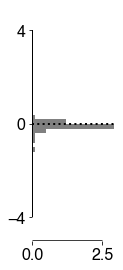

In [23]:
plt.figure()
ax = plt.gca()
utils.set_size([1.5,3])

plt.axhline(y=0, linestyle='dotted', color='k', linewidth=2)
plt.hist(d_bpost, bins=50, range=[-lim,lim], color='gray', 
         orientation='horizontal', density=True)

plt.xlim([0,3])
plt.ylim([-lim,lim])

utils.draw_publish_axis(ax, xrange=(0,2.5), yrange=(-4,4), xticks=None, yticks=[-4,0,4])
plt.savefig(f'{utils.DIR_FIGURE}/fig6e_right.pdf',bbox_inches='tight')
plt.show()

In [24]:
ttest  = DescrStatsW(d_bpost)
wilcox = wilcoxon(d_bpost)
print("d_bpost vs. 0")
print('\nOne-sample t-test (two-sided)')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nOne-sample t-test (one-sided)')
if ttest.ttest_mean()[0] < 0:
    p_val = ttest.ttest_mean()[1]/2
else:
    p_val = (1.-ttest.ttest_mean()[1])/2
print('t(49)=',  ttest.ttest_mean()[0], 'p=', p_val)
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

d_bpost vs. 0

One-sample t-test (two-sided)
t(49)= -3.1813495492795347 p= 0.002544125655828158
95% CI= (-0.15043934118912894, -0.03395945101932592)

One-sample t-test (one-sided)
t(49)= -3.1813495492795347 p= 0.001272062827914079

Wilcoxon signed-rank test (without continuity correction)
V= 262.0 p= 0.00028917828473891855


---
## DDM: reduced model

In [25]:
d_bpre  = dcb_ddm['bpre'][1,:,1]  - dcb_ddm['bpre'][1,:,0]
d_bpost = dcb_ddm['bpost'][1,:,1] - dcb_ddm['bpost'][1,:,0]

In [26]:
X = np.array([d_bpre]).T
y = np.array([d_bpost]).T
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

spear = spearmanr(d_bpre,d_bpost)
pears = pearsonr(d_bpre,d_bpost)
pears_CI = utils.pearson_CI(d_bpre,d_bpost)
print('Relation between d_bpre and d_bpost')
print('\nLinear regression')
print(f'Coefficient: {est2.params[-1]}')
print(f'p-value: {est2.pvalues[-1]}')
print('\nCorrelation coefficient')
print('Pearson r=', pears[0], 'p=', pears[1])
print('Pearson CI=', pears_CI)
print('Spearman rho=', spear.correlation, 'p=', spear.pvalue)
print(spearmanr(d_bpre,d_bpost))

Relation between d_bpre and d_bpost

Linear regression
Coefficient: 1.8133174491809603e-05
p-value: 0.9860434909343216

Correlation coefficient
Pearson r= 0.0025380452252414393 p= 0.9860434909343215
Pearson CI= (-0.27600465930594587, 0.28068746953724016)
Spearman rho= 0.02665066026410564 p= 0.8542372197436356
SpearmanrResult(correlation=0.02665066026410564, pvalue=0.8542372197436356)


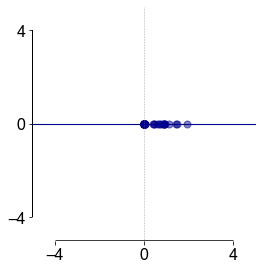

In [27]:
lim = 5
plt.figure()
ax = plt.gca()
utils.set_size([3,3])

plt.axvline(x=0, linestyle='dotted', color='gray', linewidth=0.6)
plt.axhline(y=0, linestyle='dotted', color='gray', linewidth=0.6)
plt.scatter(d_bpre, d_bpost, color='darkblue', alpha=0.5, s=50)

x_line  = np.linspace(-lim,lim,100)
x_mean  = np.mean(d_bpre)
se_line = est2.scale * (1/50 + (x_line-x_mean)**2/np.sum((d_bpre-x_mean)**2))
se_line = se_line**0.5
y_line = est2.params[0] + x_line * est2.params[1]
plt.plot(x_line, y_line, color='darkblue', linewidth=1.1)
plt.fill_between(x_line, y_line-se_line, y_line+se_line, color='darkblue', alpha=0.1, linewidth=0, zorder=-3)

plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

utils.draw_publish_axis(ax, xrange=(-4,4), yrange=(-4,4), xticks=[-4,0,4], yticks=[-4,0,4])
plt.savefig(f'{utils.DIR_FIGURE}/fig6f_left.pdf',bbox_inches='tight')
plt.show()

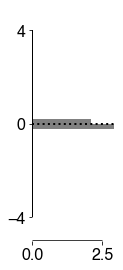

In [28]:
plt.figure()
ax = plt.gca()
utils.set_size([1.5,3])

plt.axhline(y=0, linestyle='dotted', color='k', linewidth=2)
plt.hist(d_bpost, bins=50, range=[-lim,lim], color='gray', 
         orientation='horizontal', density=True)

plt.xlim([0,3])
plt.ylim([-lim,lim])

utils.draw_publish_axis(ax, xrange=(0,2.5), yrange=(-4,4), xticks=None, yticks=[-4,0,4])
plt.savefig(f'{utils.DIR_FIGURE}/fig6f_right.pdf',bbox_inches='tight')
plt.show()

In [29]:
ttest  = DescrStatsW(d_bpost)
wilcox = wilcoxon(d_bpost)
print("d_bpost vs. 0")
print('\nOne-sample t-test (two-sided)')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nOne-sample t-test (one-sided)')
if ttest.ttest_mean()[0] < 0:
    p_val = ttest.ttest_mean()[1]/2
else:
    p_val = (1.-ttest.ttest_mean()[1])/2
print('t(49)=',  ttest.ttest_mean()[0], 'p=', p_val)
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

d_bpost vs. 0

One-sample t-test (two-sided)
t(49)= -0.591872091922898 p= 0.5566574047675084
95% CI= (-0.0012732456605108967, 0.0006938769645029764)

One-sample t-test (one-sided)
t(49)= -0.591872091922898 p= 0.2783287023837542

Wilcoxon signed-rank test (without continuity correction)
V= 542.0 p= 0.35658693993847124
